In [2]:
! pip install matplotlib

In [3]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn

In [4]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataloaders + Datasets + preprocessing

Note: AlexNet accepts images of size 227x227

In [5]:
# Resize the image and do a center crop, and store them on a tensor
import torchvision.transforms as transforms
img_size = (227, 227)
batch_size=32
train_data_dir = '/home/jovyan/BrainTumour/Training'
test_data_dir = '/home/jovyan/BrainTumour/Testing'

#preprocessing : standardizing the sizes 
#datsets and dataloaders
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir,transform=transform)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [7]:
test_loader.dataset.classes

['glioma', 'meningioma', 'notumor', 'pituitary']

## Model definition

In [8]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=4,dropoutfc=0.5,dropoutfc1=0.5):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(dropoutfc),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(dropoutfc1),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## trainer code

In [9]:
def train(model, train_loader, test_loader,training_name,saved_weights_dir, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
        savedDir=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth'
        torch.save(model.state_dict(), savedDir)
        print(f'saved weights to {savedDir}')
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [10]:
#accuracy graph
def plot_graph(train_acc, test_acc):
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()

In [11]:
def plot_loss_graph(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss vs. Epochs')
    plt.legend()
    plt.show()

## Tester code

In [12]:
#loads weights, run against all test and train for all epochs to recreate loss and accuracy graph
def load_weights_and_test(model,test_loader,epochs,training_name,saved_weights_dir):
    criterion = nn.CrossEntropyLoss()    
    # recreate test
    test_losses = []
    test_accuracies = []
    
    
    for epoch in range(epochs):
        print(epoch)
        path_model_params=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth' #edit this accordingly to folder
        model.load_state_dict(torch.load(path_model_params))
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')    
    return test_losses, test_accuracies

In [13]:
def plot_test_acc(test_acc):
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(' Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()

In [14]:
def plot_test_loss(test_loss):
    
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(' Test Loss vs. Epochs')
    plt.legend()
    plt.show()

## Model 1 : Vanilla AlexNet

In [31]:
model = AlexNet().to(device)
print(model)
training_name="AlexNet1"
saved_weights_dir="/home/jovyan/AlexNet_weights"
max_epochs=15

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.53125
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.5
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.6145833333333334
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.6015625
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.61875
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.6510416666666666
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.6696428571428571
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.6640625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.6701388888888888
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.6625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.6704545454545454
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.6614583333333334
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.6634615384615384
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.6629464285714286
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.6625
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.67

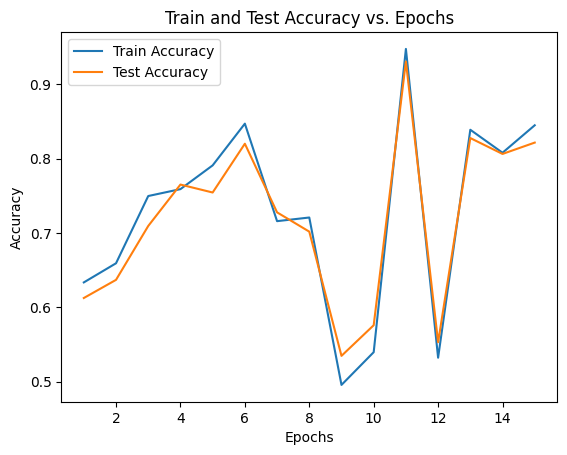

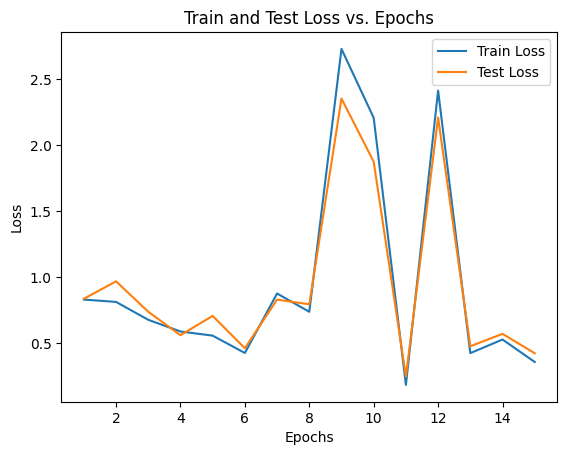

In [32]:
#do not need to run this cell again
#train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     #train_loader, \
                                                                     #test_loader, \
                                                                     #training_name= training_name,\
                                                                     #saved_weights_dir=saved_weights_dir,\
                                                                     #epochs = max_epochs, \
                                                                     #lr = 1e-3)


# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.8344, Test accuracy: 0.6125
1
--- Epoch 2/15: Test loss: 0.9668, Test accuracy: 0.6369
2
--- Epoch 3/15: Test loss: 0.7364, Test accuracy: 0.7094
3
--- Epoch 4/15: Test loss: 0.5586, Test accuracy: 0.7651
4
--- Epoch 5/15: Test loss: 0.7048, Test accuracy: 0.7544
5
--- Epoch 6/15: Test loss: 0.4593, Test accuracy: 0.8200
6
--- Epoch 7/15: Test loss: 0.8284, Test accuracy: 0.7277
7
--- Epoch 8/15: Test loss: 0.7926, Test accuracy: 0.7018
8
--- Epoch 9/15: Test loss: 2.3528, Test accuracy: 0.5347
9
--- Epoch 10/15: Test loss: 1.8740, Test accuracy: 0.5759
10
--- Epoch 11/15: Test loss: 0.2448, Test accuracy: 0.9306
11
--- Epoch 12/15: Test loss: 2.2092, Test accuracy: 0.5530
12
--- Epoch 13/15: Test loss: 0.4747, Test accuracy: 0.8276
13
--- Epoch 14/15: Test loss: 0.5685, Test accuracy: 0.8063
14
--- Epoch 15/15: Test loss: 0.4215, Test accuracy: 0.8215


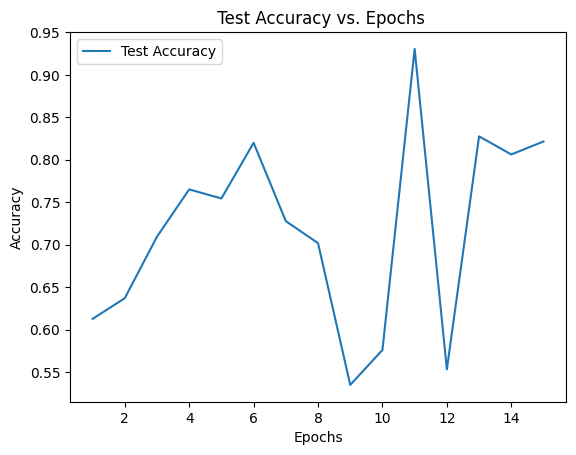

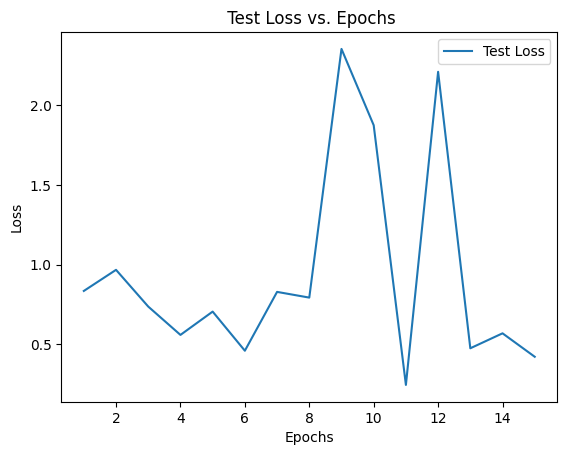

In [18]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [19]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9305873379099924
epoch:  11


## Model 2

In [33]:
model = AlexNet(dropoutfc=0.25,dropoutfc1=0.25).to(device)
print(model)
training_name="AlexNet2"
saved_weights_dir="/home/jovyan/AlexNet_weights"
max_epochs=15

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.71875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.75
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.7395833333333334
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.6953125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.69375
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.6979166666666666
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.7142857142857143
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.72265625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.7222222222222222
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.7125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.7159090909090909
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.7213541666666666
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.7235576923076923
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.7299107142857143
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.7395833333333334
Epoch 1/15, Batch number: 15, Cumulated 

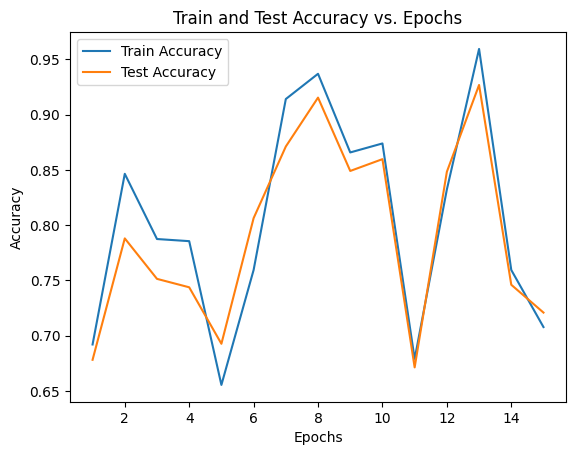

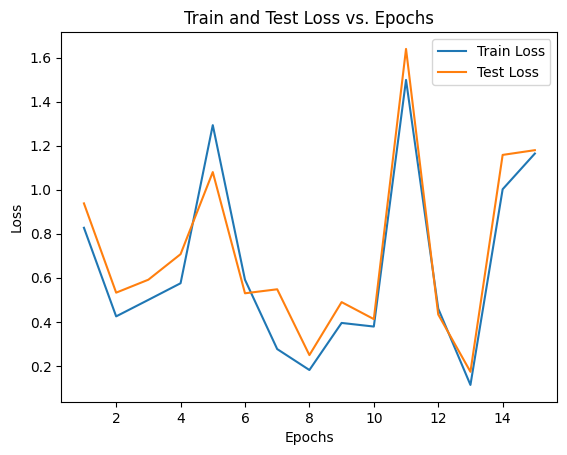

In [34]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)


# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.9377, Test accuracy: 0.6781
1
--- Epoch 2/15: Test loss: 0.5324, Test accuracy: 0.7879
2
--- Epoch 3/15: Test loss: 0.5912, Test accuracy: 0.7513
3
--- Epoch 4/15: Test loss: 0.7072, Test accuracy: 0.7437
4
--- Epoch 5/15: Test loss: 1.0798, Test accuracy: 0.6926
5
--- Epoch 6/15: Test loss: 0.5296, Test accuracy: 0.8063
6
--- Epoch 7/15: Test loss: 0.5478, Test accuracy: 0.8711
7
--- Epoch 8/15: Test loss: 0.2489, Test accuracy: 0.9153
8
--- Epoch 9/15: Test loss: 0.4895, Test accuracy: 0.8490
9
--- Epoch 10/15: Test loss: 0.4123, Test accuracy: 0.8596
10
--- Epoch 11/15: Test loss: 1.6390, Test accuracy: 0.6712
11
--- Epoch 12/15: Test loss: 0.4334, Test accuracy: 0.8482
12
--- Epoch 13/15: Test loss: 0.1732, Test accuracy: 0.9268
13
--- Epoch 14/15: Test loss: 1.1578, Test accuracy: 0.7460
14
--- Epoch 15/15: Test loss: 1.1793, Test accuracy: 0.7208


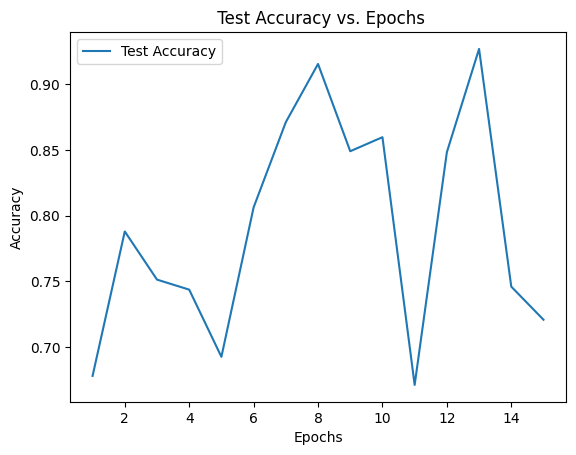

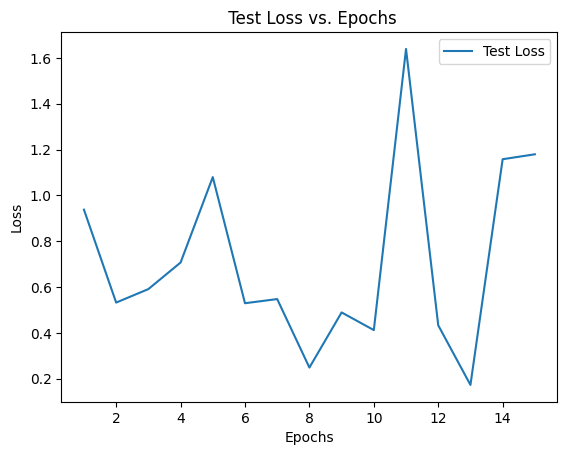

In [16]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

## Model 3

In [35]:
model = AlexNet(dropoutfc=0.75,dropoutfc1=0.75).to(device)
print(model)
training_name="AlexNet3"
saved_weights_dir="/home/jovyan/AlexNet_weights"
max_epochs=15

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.359375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3541666666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.38125
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.35714285714285715
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.36328125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.3645833333333333
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.353125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.35795454545454547
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.3541666666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.3581730769230769
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.3549107142857143
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.3625
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.369140625
E

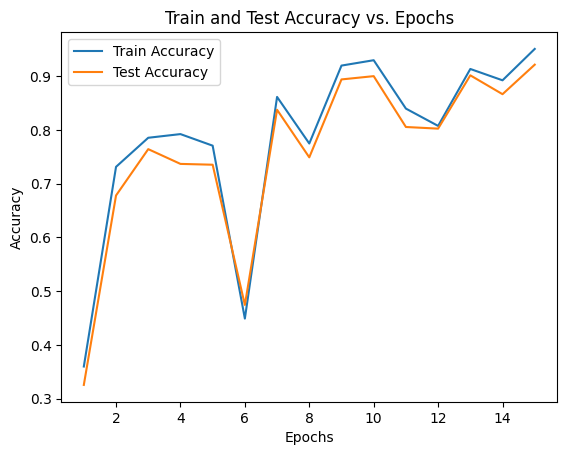

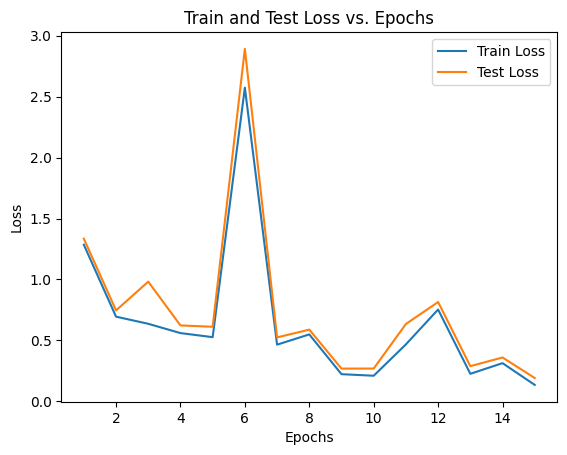

In [36]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 1.3344, Test accuracy: 0.3257
1
--- Epoch 2/15: Test loss: 0.7456, Test accuracy: 0.6781
2
--- Epoch 3/15: Test loss: 0.9818, Test accuracy: 0.7643
3
--- Epoch 4/15: Test loss: 0.6224, Test accuracy: 0.7368
4
--- Epoch 5/15: Test loss: 0.6114, Test accuracy: 0.7353
5
--- Epoch 6/15: Test loss: 2.8920, Test accuracy: 0.4744
6
--- Epoch 7/15: Test loss: 0.5240, Test accuracy: 0.8375
7
--- Epoch 8/15: Test loss: 0.5879, Test accuracy: 0.7490
8
--- Epoch 9/15: Test loss: 0.2680, Test accuracy: 0.8940
9
--- Epoch 10/15: Test loss: 0.2685, Test accuracy: 0.9001
10
--- Epoch 11/15: Test loss: 0.6341, Test accuracy: 0.8055
11
--- Epoch 12/15: Test loss: 0.8145, Test accuracy: 0.8024
12
--- Epoch 13/15: Test loss: 0.2879, Test accuracy: 0.9016
13
--- Epoch 14/15: Test loss: 0.3593, Test accuracy: 0.8665
14
--- Epoch 15/15: Test loss: 0.1908, Test accuracy: 0.9214


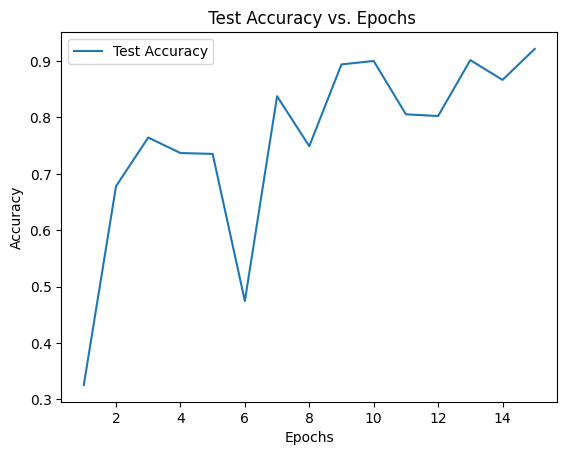

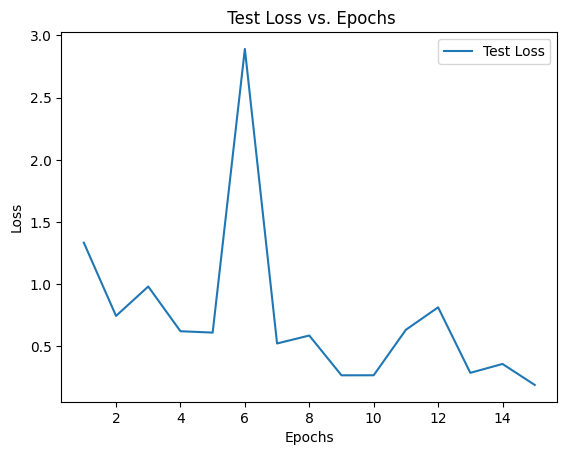

In [21]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [22]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9214340198321892
epoch:  15


## Model 4

In [37]:
model = AlexNet(dropoutfc=0.5,dropoutfc1=0.25).to(device)
print(model)
training_name="AlexNet4"
saved_weights_dir="/home/jovyan/AlexNet_weights"
max_epochs=15

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.5625
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.6875
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.7291666666666666
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.7265625
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.725
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.7395833333333334
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.7366071428571429
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.75
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.7569444444444444
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.753125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.7471590909090909
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.7421875
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.7379807692307693
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.7321428571428571
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.7354166666666667
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.73

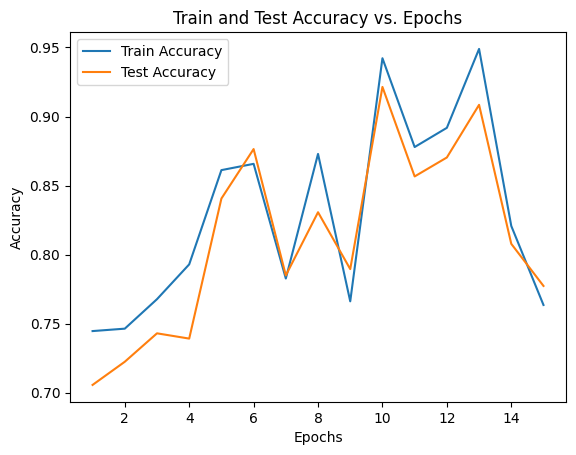

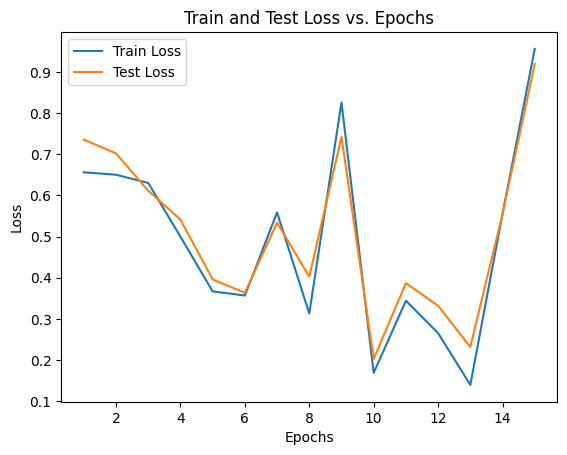

In [38]:
#do not need to run this cell again
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-3)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.7356, Test accuracy: 0.7056
1
--- Epoch 2/15: Test loss: 0.7018, Test accuracy: 0.7223
2
--- Epoch 3/15: Test loss: 0.6113, Test accuracy: 0.7429
3
--- Epoch 4/15: Test loss: 0.5410, Test accuracy: 0.7391
4
--- Epoch 5/15: Test loss: 0.3958, Test accuracy: 0.8406
5
--- Epoch 6/15: Test loss: 0.3632, Test accuracy: 0.8764
6
--- Epoch 7/15: Test loss: 0.5336, Test accuracy: 0.7849
7
--- Epoch 8/15: Test loss: 0.4023, Test accuracy: 0.8307
8
--- Epoch 9/15: Test loss: 0.7422, Test accuracy: 0.7895
9
--- Epoch 10/15: Test loss: 0.2026, Test accuracy: 0.9214
10
--- Epoch 11/15: Test loss: 0.3868, Test accuracy: 0.8566
11
--- Epoch 12/15: Test loss: 0.3316, Test accuracy: 0.8703
12
--- Epoch 13/15: Test loss: 0.2318, Test accuracy: 0.9085
13
--- Epoch 14/15: Test loss: 0.5545, Test accuracy: 0.8078
14
--- Epoch 15/15: Test loss: 0.9196, Test accuracy: 0.7773


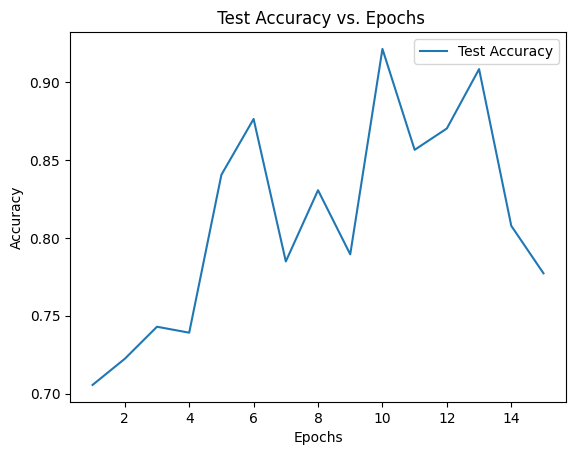

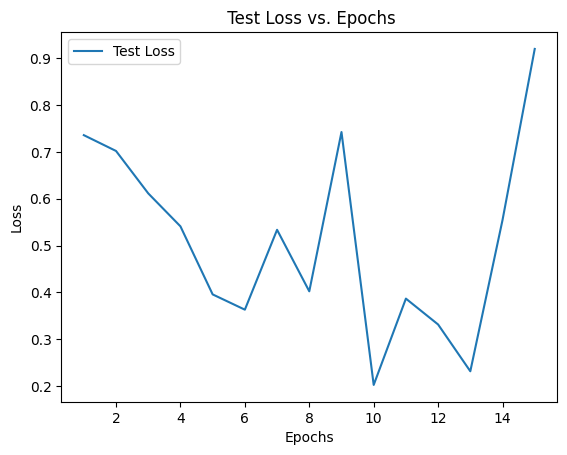

In [24]:
#run this cell to load trained weights
#recreate the test graphs
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_acc(test_accuracies)
plot_test_loss(test_losses)

In [25]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.9214340198321892
epoch:  10
